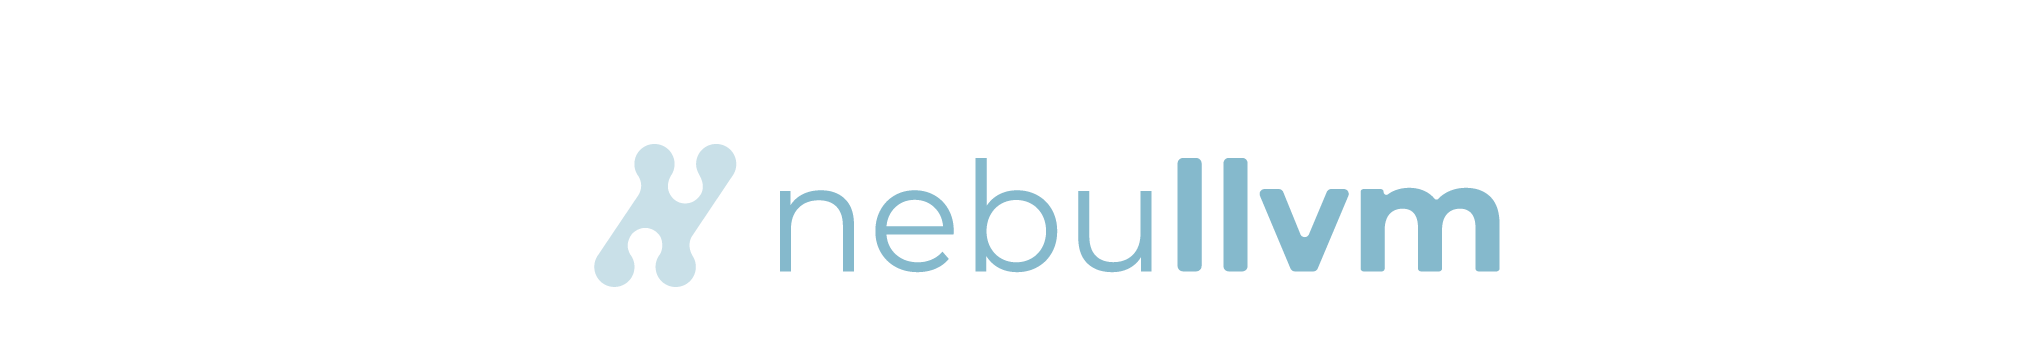

#Accelerate Tensorflow ResNet50 with nebullvm
Hi and welcome 👋

In this notebook we will discover how in just a few steps you can speed up the response time of deep learning model inference using the open-source library `nebullvm`.

We will
1. Install nebullvm and the deep learning compilers used by the library.
2. Speed up a PyTorch ResNet50 without any loss of accuracy.
3. Achieve faster acceleration on the same model by applying more aggressive optimization techniques (e.g. pruning, quantization) under the constraint of sacrificing up to 2% accuracy.

Let's jump to the code.

In [ ]:
%env CUDA_VISIBLE_DEVICES=0

#Installation

In [ ]:
%pip install nebullvm

Note that tensorflow is not listed in nebullvm requirements.txt, so it will not be installed by default. If you want to use nebullvm with a tensorflow model you have to install it separately.

In [4]:
!pip install "tensorflow<=2.10"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This is an optional step. Run it if you want to contribute to continuous improvement of `nebullvm` and share the performance achieved with it. You can find full details in the [docs](https://nebuly.gitbook.io/nebuly/nebullvm/how-nebullvm-works/fostering-continuous-improvement#sharing-feedback-to-improve-nebullvm).

In [2]:
json_feedback = {
    "allow_feedback_collection": True
}
import json
from pathlib import Path

(Path.home() / ".nebullvm").mkdir(exist_ok=True)
with open(Path.home() / ".nebullvm/collect.json", "w") as f:
  json.dump(json_feedback, f)

Let's now import nebullvm. During the import we will install the deep learning compilers used by nebullvm that are not yet installed on the hardware.

The installation of the compilers may take a few minutes.

In [ ]:
import nebullvm

# Optimization example with Tensorflow

In the following example we will try to optimize a standard resnet50 loaded directly from keras.

Nebullvm can accelerate neural networks without loss of a user-defined precision metric, e.g. accuracy, or can achieve faster acceleration by applying more aggressive optimization techniques, such as pruning and quantization, that may have a negative impact on the selectic metric. The maximum threshold value for accuracy loss is determined by the metric_drop_ths parameter. Read more in the [docs](https://nebuly.gitbook.io/nebuly/nebullvm/get-started).

Let first test the optimization without accuracy loss (metric_drop_ths=0, default value), and then apply further accelerate it under the constrained of losing up to 2% of accuracy (metric = "accuracy", metric_drop_ths = 0.02).

## Scenario 1 - No accuracy drop

First we load the model and optimize it using the nebullvm API:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from nebullvm.api.functions import optimize_model

# Load a resnet as example
model = ResNet50()

# Provide an input data for the model    
input_data = [((tf.random.normal([1, 224, 224, 3]),), 0)]

# Run nebullvm optimization
optimized_model = optimize_model(
  model, input_data=input_data, optimization_time="unconstrained"
)

# Try the optimized model
x = tf.random.normal([1, 224, 224, 3])
res_original = model.predict(x)
res_optimized = optimized_model.predict(x)[0]

We can print the type of the optimized model to see which compiler was faster:

In [4]:
optimized_model

TensorflowNvidiaInferenceLearner(network_parameters=ModelParams(batch_size=1, input_infos=[<nebullvm.base.InputInfo object at 0x7fa5ba06e990>], output_sizes=[(1, 1000)], dynamic_info=DynamicAxisInfo(inputs=[{}], outputs=[{0: 'batch_size'}])), input_tfms=<nebullvm.transformations.base.MultiStageTransformation object at 0x7fa58723f810>)

In our case, the optimized model type was TensorflowNvidiaInferenceLearner, so this means that Tensor RT was the faster compiler.

After the optimization step, we can compare the optimized model with the baseline one in order to verify that the output is the same and to measure the speed improvement

First of all, let's print the results

In [5]:
res_original

array([[9.26722259e-06, 1.33789072e-04, 3.61283921e-04, 2.19809182e-04,
        1.69060091e-04, 3.88379012e-05, 3.10233918e-05, 2.72357953e-04,
        1.64093908e-05, 7.10838882e-04, 7.03686266e-04, 9.58472257e-04,
        3.32407944e-04, 5.10656508e-04, 5.57371786e-05, 2.04775555e-04,
        8.98001483e-04, 8.84678084e-05, 3.73550283e-04, 1.81539828e-04,
        7.58755777e-04, 3.25233676e-02, 9.71166138e-03, 4.38538939e-03,
        5.20195928e-04, 3.38206264e-05, 3.48448266e-05, 1.72038839e-04,
        9.76080701e-05, 2.92182485e-05, 4.05534738e-05, 3.01719381e-04,
        1.08031772e-05, 1.29137450e-04, 5.87158080e-04, 8.08788809e-06,
        1.19281693e-04, 7.05352022e-06, 3.60567443e-04, 2.16077970e-05,
        1.47103012e-04, 3.91198373e-05, 1.07235205e-03, 6.31312796e-05,
        1.53019748e-04, 3.63935542e-05, 1.69833977e-04, 1.97041096e-04,
        2.62060476e-05, 1.36958522e-04, 7.82130868e-04, 5.66586896e-05,
        2.78079038e-04, 7.50912528e-04, 1.09943212e-03, 7.058486

In [6]:
res_optimized

<tf.Tensor: shape=(1, 1, 1000), dtype=float32, numpy=
array([[[9.26720168e-06, 1.33789057e-04, 3.61284357e-04, 2.19808135e-04,
         1.69059844e-04, 3.88377994e-05, 3.10234464e-05, 2.72358797e-04,
         1.64094654e-05, 7.10843888e-04, 7.03686790e-04, 9.58473480e-04,
         3.32408410e-04, 5.10658370e-04, 5.57374660e-05, 2.04776356e-04,
         8.98006954e-04, 8.84681358e-05, 3.73554329e-04, 1.81540148e-04,
         7.58757524e-04, 3.25235650e-02, 9.71172377e-03, 4.38542012e-03,
         5.20196103e-04, 3.38206228e-05, 3.48447320e-05, 1.72038242e-04,
         9.76080992e-05, 2.92181467e-05, 4.05533829e-05, 3.01717984e-04,
         1.08031309e-05, 1.29136475e-04, 5.87156625e-04, 8.08787445e-06,
         1.19281547e-04, 7.05349703e-06, 3.60564300e-04, 2.16077460e-05,
         1.47102619e-04, 3.91195827e-05, 1.07234856e-03, 6.31309886e-05,
         1.53019573e-04, 3.63933614e-05, 1.69833744e-04, 1.97040586e-04,
         2.62059366e-05, 1.36957096e-04, 7.82121671e-04, 5.66582494e-0

Then, let's compute the average latency of the baseline model:

In [7]:
import time

In [8]:
num_iters = 100

# Warmup
for i in range(10):
  model.predict(x)

start = time.time()
for i in range(num_iters):
  model.predict(x)
stop = time.time()

print("Average latency original model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency original model: 0.0524 seconds


Finally we compute the average latency for the optimized model:



In [9]:
# Warmup
for i in range(10):
  optimized_model.predict(x)

start = time.time()
for i in range(num_iters):
  optimized_model.predict(x)
stop = time.time()

print("Average latency optimized model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency optimized model: 0.0071 seconds


## Scenario 2 - Accuracy drop

In this scenario, we set a max threshold for the accuracy drop to 2%

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from nebullvm.api.functions import optimize_model

# Load a resnet as example
model = ResNet50()

# Provide an input data for the model   
# Note that in this case we should provide the model at least 100 data samples
input_data = [((tf.random.normal([1, 224, 224, 3]),), 0) for i in range(100)]

# Run nebullvm optimization
optimized_model = optimize_model(
  model, input_data=input_data, optimization_time="unconstrained", metric = "accuracy", metric_drop_ths = 0.02
)

# Try the optimized model
x = tf.random.normal([1, 224, 224, 3])
res_original = model.predict(x)
res_optimized = optimized_model.predict(x)[0]

Here we compute the average throughput for the baseline model:

In [11]:
num_iters = 100

# Warmup
for i in range(10):
  model.predict(x)

start = time.time()
for i in range(num_iters):
  model.predict(x)
stop = time.time()

print("Average latency original model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency original model: 0.0520 seconds


Here we compute the average throughput for the optimized model:

In [12]:
# Warmup
for i in range(10):
  optimized_model.predict(x)

start = time.time()
for i in range(num_iters):
  optimized_model.predict(x)
stop = time.time()

print("Average latency optimized model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency optimized model: 0.0037 seconds


<center> 
    <a href="https://discord.com/invite/RbeQMu886J" target="_blank" style="text-decoration: none;"> Join the community </a> |
    <a href="https://nebuly.gitbook.io/nebuly/welcome/questions-and-contributions" target="_blank" style="text-decoration: none;"> Contribute to the library </a>
</center>

<center> 
    <a href="https://github.com/nebuly-ai/nebullvm#how-it-works" target="_blank" style="text-decoration: none;"> How nebullvm works </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#documentation" target="_blank" style="text-decoration: none;"> Documentation </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#api-quick-view" target="_blank" style="text-decoration: none;"> API quick view </a> 
</center>